In this note, we learn different ways to sample a distribution. Sampling is used to compute expectation, integrals, and do statsistics.
## Inverse Transform

Given an invertible CDF F of a distribution of x, we can perform sampling using the following algorithm.
1. get a uniform sample u from uniform(0,1)
2. sovle for x: $x = F^{-1}(u)$
3. repeat.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Exponential distribution $f(x) = \lambda e^{-\lambda x}$ for $x>0$. Solving $x = F^{-1}(u)$, we have $x = (-1/\lambda)\ln(1-u)$

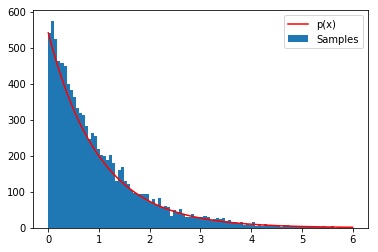

In [39]:
# drawing from exponential distribution f(x,1), lambda=1
p = lambda x: np.exp(-x)
CDF = lambda x: 1 - np.exp(-x)
invCDF = lambda r: -np.log(1-r)
xmin = 0
xmax = 6
rmin = CDF(xmin)
rmax = CDF(xmax)
N = 10000
# generate samples in [rmin rmax] the invert the CDF 
# to get the samples of our target distribution
R = np.random.uniform(rmin,rmax, N)
X = invCDF(R)
hinfo = np.histogram(X,100)
plt.hist(X, bins=100, label='Samples')

# plot our (normalized) function
x = np.linspace(xmin,xmax,1000)
plt.plot(x, hinfo[0][0]*p(x), color='r', label=u'p(x)')
plt.legend()


## Rejection Sampling
This is quite simple. The key idea is to generate samples from a uniform distribution with a support as a rectangle [xmin, xmax] * [0, ymax], see how many fall below y(x) at a specific x.

The algorithm is as follows.
1. Draw x uniformly from [xmin, xmax]
2. Draw y uniformly from [0, ymax]
3. if y < f(x), accept the sample x
4. otherwise reject it
5. repeat

The following code generate samples from distribution $f(x) = e^{-x}$ for $x \in[0,10]$

Count 101133 Accepted 10000


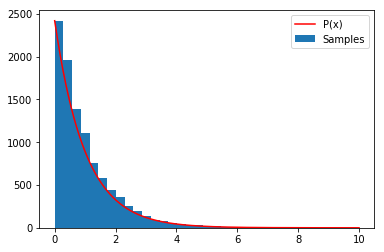

In [42]:
P = lambda x: np.exp(-x)

# domain limits
xmin = 0 # the lower limit of our domain
xmax = 10 # the upper limit of our domain

# range limit (supremum) for y
ymax = 1
#you might have to do an optimization to find this.

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals

# generation loop
while (accepted < N):
    
    # pick a uniform number on [xmin, xmax) (e.g. 0...10)
    x = np.random.uniform(xmin, xmax)
    
    # pick a uniform number on [0, ymax)
    y = np.random.uniform(0,ymax)
    
    # Do the accept/reject comparison
    if y < P(x):
        samples[accepted] = x
        accepted += 1
    
    count +=1
    
print("Count",count, "Accepted", accepted)

# get the histogram info
hinfo = np.histogram(samples,30)

# plot the histogram
plt.hist(samples,bins=30, label=u'Samples');

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, hinfo[0][0]*P(xvals), 'r', label=u'P(x)')

# turn on the legend
plt.legend()


Notice that we need about 100K proposals to accept 10K samples. This is very inefficient. This is because in the range $[4,10]$, we have a very low probabilty density. This problem is called **low acceptance probability**. To solve this, we can introduct a **proposal density g(x)**, which should have the following properties:
- easy to sample from
- M is beween 1, and $\infty$ so that Mg(x) > f(x) on the entire domain of interest
- ideally g(x) will be somewhat close to f so that you will sample more in the high density regions and less in the low density regions. 

There are two equivalent view of this strategy: Algorithm 1 and Algorithm 2. Algorithm 1 is more direct, easy to understand.

Algorithm 1:
Note that in the picture $g(x)$ is $Q(x)$ and f(x) is $P^*(x)$.

![rejection sampling](./gfx/rejection_sampling.png)



Algorithm 2:
- Draw x from your proposal distribution g(x)
- Draw y uniformly from [0,1] 
- if y< f(x)/Mg(x)accept the sample otherwise reject it repeat


Notice that the two algorithm are equivalent. In Algorithm 2, step 3, $y < f(x)/Mg(x)$ is equivalent to $yMg(x) < f(x)$, since y is choosen uniformly from $[0,1]$. This is equivalent to sampling from $[0, Mg(x)]$ (or $[0, CQ(x)]$ as in the picture) which is like in the Algorithm 1.


Count 23868 Accepted 10000


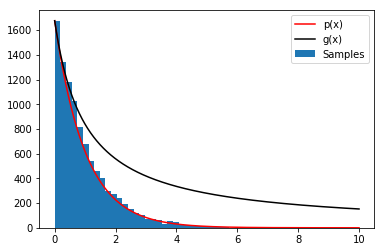

In [48]:
p = lambda x: np.exp(-x)  # our distribution
g = lambda x: 1/(x+1)  # our proposal pdf (we're thus choosing M to be 1)
invCDFg = lambda x: np.log(x +1) # generates our proposal using inverse sampling

# domain limits
xmin = 0 # the lower limit of our domain
xmax = 10 # the upper limit of our domain

# range limits for inverse sampling
umin = invCDFg(xmin)
umax = invCDFg(xmax)

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals

# generation loop
while (accepted < N):
    
    # Sample from g using inverse sampling
    u = np.random.uniform(umin, umax)
    xproposal = np.exp(u) - 1
    
    # pick a uniform number on [0, 1)
    y = np.random.uniform(0,1)
    
    # Do the accept/reject comparison
    if y < p(xproposal)/g(xproposal):
        samples[accepted] = xproposal
        accepted += 1
    
    count +=1
    
print("Count", count, "Accepted", accepted)

# get the histogram info
hinfo = np.histogram(samples,50)

# plot the histogram
plt.hist(samples,bins=50, label=u'Samples');

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, hinfo[0][0]*p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, hinfo[0][0]*g(xvals), 'k', label=u'g(x)')

# turn on the legend
plt.legend()

One clear effect is that we need 24109 proposal to get 10K samples.

## Importance Sampling

This is a directly a method to compute integrals, which we need to perform Bayes analysis.

For example suppose we have $X \sim f(x)$, and we want to compute $E(h(x))$ wrt to this density, we have 


$\begin{align}
    E_f[h] &= \int_{V}f(x)h(x)dx\\
            &= \int h(x)g(x)\frac{f(x)}{g(x)}dx
            &= E_g[h(x)\frac{f(x)}{g(x)}]
\end{align}$

Here $g(x)$ is a function that is easy to sample from and is close to the function $f(x)$. Now we can approximate the last expression by Monte Carlo methods 

$$E_f[h] = \lim_{N \rightarrow \infty}\frac{1}{N}\sum_{x_i \sim g(.)}h(x_i)\frac{f(x_i)}{g(x_i)}$$

The fundamental difference compared to rejection sampling is we use all the samples. But the contribution to the expection is weighted by $w(x_i) = \frac{f(x_i)}{g(x_i)}$

Example: Calculate $\int_{0}^{\pi}sin(x)xdx$

The function has a shape that is similar to Gaussian and therefore we choose here a Gaussian as importance sampling distribution.

In [12]:
from scipy import stats
from scipy.stats import norm

mu = 2;
sig =.7;

f = lambda x: np.sin(x)*x
infun = lambda x: np.sin(x)-x*np.cos(x)
p = lambda x: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(x-mu)**2/(2.0*sig**2))
normfun = lambda x:  norm.cdf(x-mu, scale=sig)


Exact solution is:  3.141592653589793


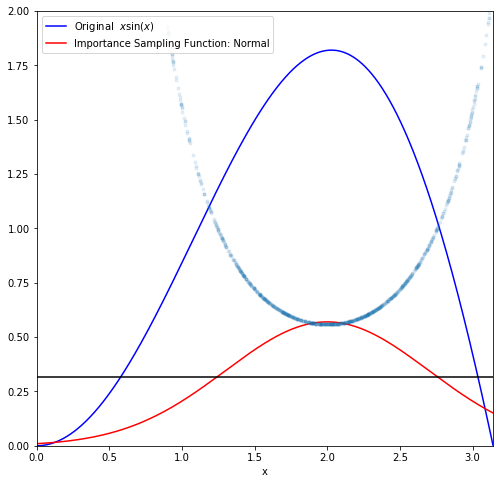

In [39]:
plt.figure(figsize=(18,8))  # set the figure size


# range of integration
xmax =np.pi 
xmin =0

# Number of draws 
N =1000

# Just want to plot the function
x=np.linspace(xmin, xmax, 1000)
plt.subplot(1,2,1)
plt.plot(x, f(x), 'b', label=u'Original  $x\sin(x)$')
plt.plot( x, p(x), 'r', label=u'Importance Sampling Function: Normal')
plt.plot(x, np.ones(1000)/np.pi,'k')

# drawing from normal distribution
xis = mu + sig*np.random.randn(N,1);
plt.plot(xis, 1/(np.pi*p(xis)),'.', alpha=0.1)

# some plotting miscell
plt.xlim([0, np.pi])
plt.ylim([0,2])
plt.xlabel('x')
plt.legend()
# =============================================
# EXACT SOLUTION 
# =============================================
Iexact = infun(xmax)-infun(xmin)
print("Exact solution is: ", Iexact)

Mean basic MC estimate:  3.14263399245922
Standard deviation of our estimates:  0.06016872403795413
Mean importance sampling MC estimate:  3.1415904991728296
Standard deviation of our estimates:  0.015732597782855223


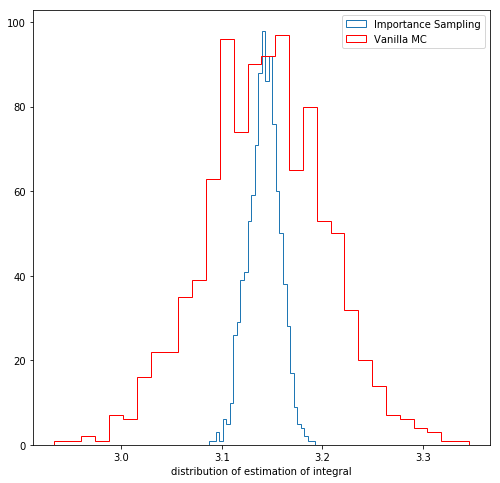

In [40]:
plt.figure(figsize=(18,8))
# ============================================
# VANILLA MONTE CARLO 
# ============================================
Ivmc = np.zeros(1000)
for k in np.arange(0,1000):
    x = np.random.uniform(low=xmin, high=xmax, size=N)
    Ivmc[k] = (xmax-xmin)*np.mean( f(x))

print("Mean basic MC estimate: ", np.mean(Ivmc))
print("Standard deviation of our estimates: ", np.std(Ivmc))

# ============================================
# IMPORTANCE SAMPLING 
# ============================================
# CHOOSE Gaussian so it similar to the original functions

Iis = np.zeros(1000)
for k in np.arange(0,1000):
    # DRAW FROM THE GAUSSIAN mean =2 std = sqrt(0.7) 
    xis = mu + sig*np.random.randn(N,1);
    #hist(x)
    xis = xis[ (xis<xmax) & (xis>xmin)] ;

    # normalization for gaussian from 0..pi
    normal = normfun(np.pi)-normfun(0);


    Iis[k] =np.mean(f(xis)/p(xis))*normal;

print("Mean importance sampling MC estimate: ", np.mean(Iis))
print("Standard deviation of our estimates: ", np.std(Iis))
plt.subplot(1,2,2)
plt.hist(Iis,30, histtype='step', label=u'Importance Sampling');
plt.hist(Ivmc, 30, color='r',histtype='step', label=u'Vanilla MC');
plt.gca().set_xlabel('distribution of estimation of integral')
plt.legend()

In [41]:
sig

0.7